BloomTech Data Science

*Unit 2, Sprint 2, Module 2*

---

# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Join the kaggle competition, and download the water pump dataset.
- **Task 2:** Modify `wrangle` function to engineer a new feature. Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and validation sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_rf`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` and `n_estimators` to reduce overfitting.
- **Task 9:** Generate list of predictions for `X_test`.
- **Task 9 `stretch goal`:** Create `submissions.csv` file and upload on kaggle competition site.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `ydata-profiling`
- `sklearn`

# I. Wrangle Data

In [1]:
import pandas as pd
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [2]:
df = wrangle("C:/Users/ISHMO_CT/downloads/Bloomtech-Random-Forests/Data-sets/train_features.csv",
             "C:/Users/ISHMO_CT/downloads/Bloomtech-Random-Forests/Data-sets/train_labels.csv")
X_test = wrangle("C:/Users/ISHMO_CT/downloads/Bloomtech-Random-Forests/Data-sets/test_features.csv")

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [4]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [8]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [31]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1, max_samples=0.6)
)

model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
improved spring       3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_samples=0.6, n_jobs=-1,
                                        random_state=42))])

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [32]:
from sklearn.metrics import accuracy_score
training_acc = accuracy_score(y_train, model_rf.predict(X_train))
val_acc = accuracy_score(y_val, model_rf.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9736156780218335
Validation Accuracy Score: 0.8010311447811448


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`.

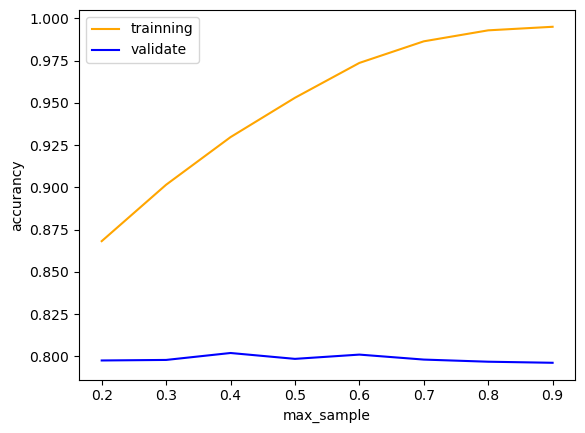

In [22]:
import numpy as np
train_acc = []
val_acc = []
max_samples_list = np.arange(0.2,1, 0.1)

for sample in max_samples_list:
    model_rf_tune = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='mean'),
        RandomForestClassifier(random_state=42, n_jobs=-1, max_samples=sample)
    )

    model_rf_tune.fit(X_train, y_train)

    # check out the metrics of different depth samples
    train_acc.append(model_rf_tune.score(X_train, y_train))
    val_acc.append(model_rf_tune.score(X_val, y_val))

# Lets plot our depths against the accuracy to determine the right depth lto use to fine tune oue model
import matplotlib.pyplot as plt

plt.plot(max_samples_list, train_acc, color='orange', label = 'trainning')
plt.plot(max_samples_list, val_acc, color='blue', label = 'validate')
plt.xlabel('max_sample')
plt.ylabel('accurancy')
plt.legend()
plt.show()

# According to our graph the curve starts bending at 0.7 max depth

# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

In [34]:
y_pred = model_rf.predict(X_test)

assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site.

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting.

In [36]:
submission = pd.DataFrame(data=y_pred, index=X_test.index)
submission.columns = ['status_group']
submission
submission.to_csv('ass_submission.csv')